In [146]:
import re
import time
import math
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing 
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

 

# Predicting Airline Arrival Delays

Flight delays are a hastle for passengers and the airlines themselves. It costs all involved time and money. Being able to predict how flight delays can help the airlines make better decisions to prevend future delays and it could help passengers be able to plan accordingly for other travel arrangements. The focus of this report will be on predicting arrival delays. For our purposes a flight will only be considered late if it is over 30 minutes delayed.

In [147]:
# Load data
arrivals = pd.read_csv('C:/Users/keith/Desktop/Thinkful/2008.csv',encoding = "ISO-8859-1")

pd.set_option('display.max_columns', None) # disables trucated columns 
pd.set_option('display.max_rows', None) # disables trucated rows


In [148]:
arrivals.shape

(7009728, 29)

In [149]:
arrivals.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,N612SW,88.0,90.0,78.0,-6.0,-4.0,IND,BWI,515,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


# Data Description

The data we will be exploring comes from The Bureau of Transportation Statistics and the particular data set is from 2008. It consists of 29 features and 7,009,728 rows of flight observations.  

In [150]:
arrivals.columns 

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

### Brief description of features

Name	Description<br/>
1	**Year:**	      2008<br/>
2	**Month:**	1-12<br/>
3	**DayofMonth:**	1-31<br/>
4	**DayOfWeek:**	1 (Monday) - 7 (Sunday)<br/>
5	**DepTime:**	actual departure time (local, hhmm)<br/>
6	**CRSDepTime:**	scheduled departure time (local, hhmm)<br/>
7	**ArrTime:**	actual arrival time (local, hhmm)<br/>
8	**CRSArrTime:**	scheduled arrival time (local, hhmm)<br/>
9	**UniqueCarrier:**	unique carrier code<br/>
10	**FlightNum:**	flight number<br/>
11	**TailNum:**	plane tail number<br/>
12	**ActualElapsedTime:**	in minutes<br/>
13	**CRSElapsedTime:**	in minutes<br/>
14	**AirTime:**	in minutes<br/>
15	**ArrDelay:**	arrival delay, in minutes<br/>
16	**DepDelay:**	departure delay, in minutes<br/>
17	**Origin:**	origin IATA airport code<br/>
18	**Dest:**	destination IATA airport code<br/>
19	**Distance:**	in miles<br/>
20	**TaxiIn:**	taxi in time, in minutes<br/>
21	**TaxiOut:**	taxi out time in minutes<br/>
22	**Cancelled:**	was the flight cancelled?<br/>
23	**CancellationCode:**	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)<br/>
24	**Diverted:**	1 = yes, 0 = no<br/>
25	**CarrierDelay:**	in minutes<br/>
26	**WeatherDelay:**	in minutes<br/>
27	**NASDelay:**	in minutes<br/>
28	**SecurityDelay:**	in minutes<br/>
29	**LateAircraftDelay:**	in minutes<br/>

# Data cleaning

In [151]:
arrivals.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime               136246
CRSDepTime                 0
ArrTime               151649
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                83365
ActualElapsedTime     154699
CRSElapsedTime           844
AirTime               154699
ArrDelay              154699
DepDelay              136246
Origin                     0
Dest                       0
Distance                   0
TaxiIn                151649
TaxiOut               137058
Cancelled                  0
CancellationCode     6872294
Diverted                   0
CarrierDelay         5484993
WeatherDelay         5484993
NASDelay             5484993
SecurityDelay        5484993
LateAircraftDelay    5484993
dtype: int64

There are several columns with missing data. Since we are only concerned with delay flights we can drop the "Cancelled" and "CanellationCode" columns.

In [152]:
# dropping 'CancellationCode','Cancelled' columns

variables_to_remove = ['CancellationCode','Cancelled','Diverted','FlightNum','TailNum']
arrivals = arrivals.drop(variables_to_remove, 1)

Over half of our data will be missing if we simply drop the rows with null values. Instead we will make a big assumption and say that there were no delays of the types with the missing values and replace the null values with zeros for zero delayed minutes.

In [153]:
arrivals.fillna({'CarrierDelay':0,
       'WeatherDelay':0, 'NASDelay':0, 'SecurityDelay':0, 'LateAircraftDelay':0}, inplace=True)

In [154]:
len(arrivals)

7009728

In [155]:
arrivals.isnull().sum()

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime              136246
CRSDepTime                0
ArrTime              151649
CRSArrTime                0
UniqueCarrier             0
ActualElapsedTime    154699
CRSElapsedTime          844
AirTime              154699
ArrDelay             154699
DepDelay             136246
Origin                    0
Dest                      0
Distance                  0
TaxiIn               151649
TaxiOut              137058
CarrierDelay              0
WeatherDelay              0
NASDelay                  0
SecurityDelay             0
LateAircraftDelay         0
dtype: int64

From here we will drop the rows containing the rest of the null values and that will still leave us with plenty of data.

In [156]:
arrivals.dropna(inplace=True)

In [157]:
arrivals.isnull().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64

In [158]:
len(arrivals)/7009728*100

97.79308127219772

In [159]:
len(arrivals)

6855029

After handling all of the null values we are still left with 97% of the original data.

Next, we are going to make a new categorical feature marks if an arrival is late or not. The ArrDelay feature shows how many minutes that a flight was delayed. We will use it to make the features "Late Arrivals" and "Late Departures" which we will label a "1" for an arrival or departure that was over 30 min delayed and a zero for all others.  

In [160]:
arrivals['Late_arrivals'] = np.where(arrivals['ArrDelay']>30, 1, 0)
arrivals['Late_departures'] = np.where(arrivals['DepDelay']>30, 1, 0)

To reduce some dimention we will combine the "Year", "Month",and "DayOfMonth" features to one "date" feature in datetime format.

In [161]:
arrivals['Day'] = arrivals['DayofMonth'] 
arrivals['date'] = pd.to_datetime(arrivals[['Year','Month','Day']])
arrivals = arrivals.drop(['Year','DayofMonth','Day','Month'],1)

In [162]:
# dictionary to match carrier codes with names
carrier_names = {'9E':'Endeavor Air Inc.',
                 'AA':'American Airlines Inc.',
                 'AS':'Alaska Airlines Inc.',
                 'B6':'JetBlue Airways',
                 'DL':'Delta Air Lines Inc.',
                 'EV':'ExpressJet Airlines Inc.',
                 'F9':'Frontier Airlines Inc.',
                 'G4':'Allegiant Air',
                 'HA':'Hawaiian Airlines Inc.',
                 'MQ':'Envoy Air',
                 'NK':'Spirit Air Lines',
                 'OH':'PSA Airlines Inc.',
                 'OO':'SkyWest Airlines Inc.',
                 'UA':'United Air Lines Inc.',
                 'WN':'Southwest Airlines Co.',
                 'YV':'Mesa Airlines Inc.',
                 'YX':'Republic Airline',
                 'XE':'ExpressJet Airlines',
                 'US':'US Airways',
                 'FL':'AirTran Airways',
                 'NW':'Northwest Airlines',
                 'AQ':'Aloha',
                 'CO':'Continental Airlines'}
carriers = []
for i in arrivals.UniqueCarrier:
    carriers.append(carrier_names[i])
arrivals['carriers'] = carriers

 # Exploratory Data Analysis
 

In [18]:
#arr_samp = arrivals.sample(frac=.001)

In [25]:
arrivals.columns

Index(['DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime',
       'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn',
       'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'Late_arrivals', 'Late_departures', 'date',
       'carriers'],
      dtype='object')

In [26]:
# Summary statistics

arrivals.describe()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Late_arrivals,Late_departures
count,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06,6.855029e+06
mean,3.925802e+00,1.333775e+03,1.325037e+03,1.481266e+03,1.493715e+03,1.273224e+02,1.290778e+02,1.040186e+02,8.168452e+00,9.923845e+00,7.287438e+02,6.860150e+00,1.644368e+01,3.508113e+00,6.759588e-01,3.817854e+00,1.667622e-02,4.620001e+00,1.314944e-01,1.181181e-01
std,1.988459e+00,4.780574e+02,4.643129e+02,5.051322e+02,4.826642e+02,7.018731e+01,6.953271e+01,6.743980e+01,3.850194e+01,3.520386e+01,5.632447e+02,4.931224e+00,1.131062e+01,2.001675e+01,9.284375e+00,1.665013e+01,8.673703e-01,2.043151e+01,3.379403e-01,3.227479e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.200000e+01,-1.410000e+02,0.000000e+00,-5.190000e+02,-5.340000e+02,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,9.280000e+02,9.250000e+02,1.107000e+03,1.115000e+03,7.700000e+01,8.000000e+01,5.500000e+01,-1.000000e+01,-4.000000e+00,3.260000e+02,4.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,1.325000e+03,1.317000e+03,1.512000e+03,1.515000e+03,1.100000e+02,1.110000e+02,8.600000e+01,-2.000000e+00,-1.000000e+00,5.810000e+02,6.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.000000e+00,1.728000e+03,1.715000e+03,1.909000e+03,1.905000e+03,1.570000e+02,1.590000e+02,1.320000e+02,1.200000e+01,8.000000e+00,9.540000e+02,8.000000e+00,1.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.359000e+03,1.379000e+03,6.600000e+02,1.350000e+03,2.461000e+03,2.467000e+03,4.962000e+03,3.080000e+02,4.290000e+02,2.436000e+03,1.352000e+03,1.357000e+03,3.920000e+02,1.316000e+03,1.000000e+00,1.000000e+00


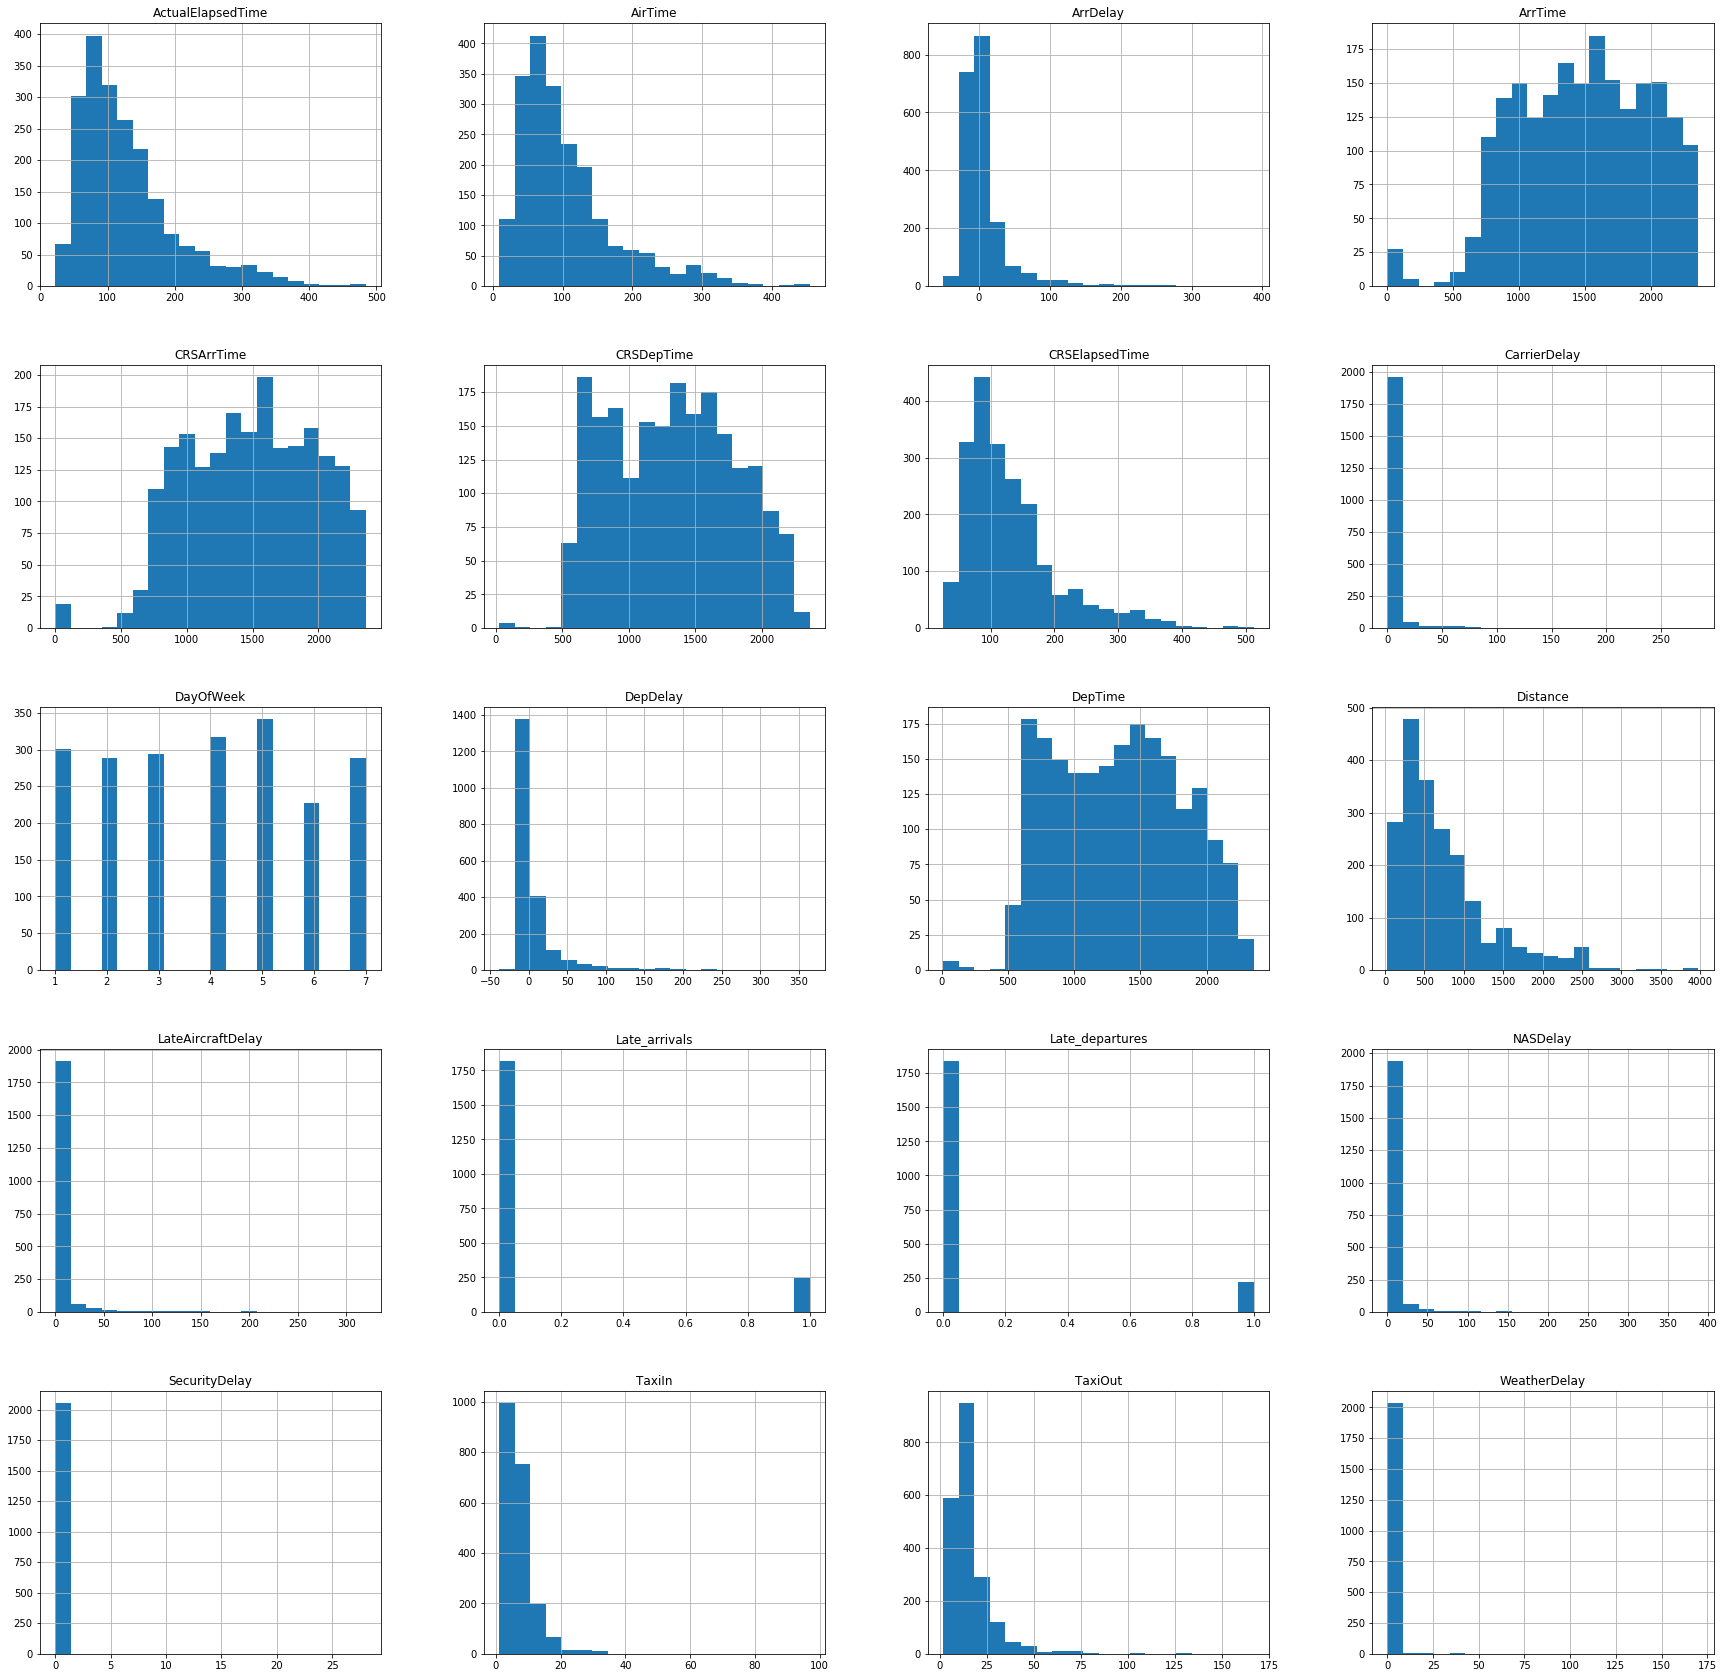

In [85]:
# Taking a look at the distribution of the features

arrivals.hist(figsize=(30,30),bins=20)
plt.show()

In [28]:
# Taking a look at how the target variable correlates with the other features

arrivals.corr()['ArrDelay']

DayOfWeek            0.010558
DepTime              0.178275
CRSDepTime           0.116894
ArrTime              0.066021
CRSArrTime           0.113087
ActualElapsedTime    0.093925
CRSElapsedTime       0.012641
AirTime              0.034732
ArrDelay             1.000000
DepDelay             0.931391
Distance             0.006551
TaxiIn               0.123065
TaxiOut              0.322101
CarrierDelay         0.564285
WeatherDelay         0.280095
NASDelay             0.513837
SecurityDelay        0.025578
LateAircraftDelay    0.605675
Late_arrivals        0.739601
Late_departures      0.702242
Name: ArrDelay, dtype: float64

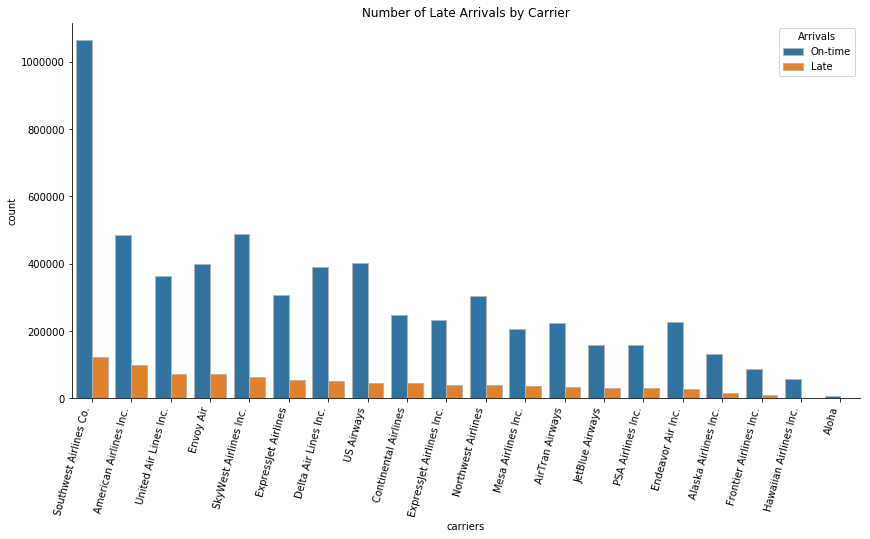

In [29]:
# plot counts of late/on-time flights per carrier

arrivals['carriers'] = carriers
sorted_carrier = list(arrivals[arrivals.Late_arrivals==1].carriers.value_counts().index)
ax = sns.catplot(x="carriers", hue="Late_arrivals", kind="count",
             edgecolor=".7", data=arrivals, order=sorted_carrier, 
            legend=False,  height=6, aspect=2)
 

ax.set_xticklabels(rotation=75,ha='right')
plt.legend(title='Arrivals', loc='best', labels=['On-time', 'Late'])
plt.title('Number of Late Arrivals by Carrier')
plt.show()

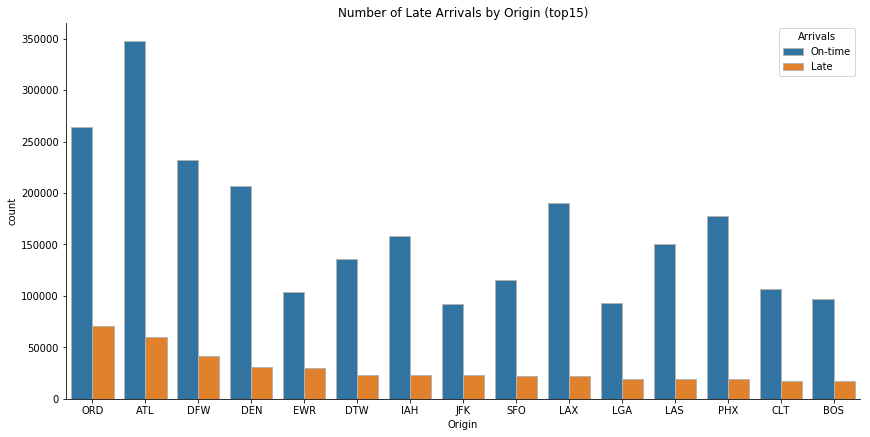

In [33]:
# plot counts of late/on-time flights per airport of origin

sorted_origin = list(arrivals[arrivals.Late_arrivals==1].Origin.value_counts().head(15).index)
sns.catplot(x="Origin", hue="Late_arrivals", kind="count",
             edgecolor=".7", data=arrivals,order=sorted_origin,
            legend=False, height=6,aspect=2) 
plt.legend(title='Arrivals', loc='best', labels=['On-time', 'Late'])
plt.title('Number of Late Arrivals by Origin (top15)')
plt.show()   
 

The above two plots show the number of late arrivals compared to the number of on-time arrivals per carrier and per airport of origin, respectively. It was better to plot it this way instead of plotting the means because there were some origins that only had one sample and it would be misleading.

Now we will take a look at a breakdown of how each carrier is affected by each type of delay

,ArrDelay,LateAircraftDelay,CarrierDelay,DepDelay,WeatherDelay,NASDelay,SecurityDelay
carriers,,,,,,,
JetBlue Airways,92.113610,37.170662,18.975717,78.996500,1.672025,34.246763,0.048442
Mesa Airlines Inc.,89.576462,20.545600,45.073370,83.939635,4.680774,19.118037,0.158680
ExpressJet Airlines,87.362891,32.312185,19.282004,77.318428,4.210174,31.419150,0.139378
United Air Lines Inc.,85.473680,40.648836,20.305456,77.960032,2.695965,21.804942,0.018481
ExpressJet Airlines Inc.,85.078774,13.652709,36.326891,78.331327,13.104828,21.930732,0.063614
Continental Airlines,84.560972,25.789815,18.933780,74.133112,4.143943,35.563798,0.129636
Hawaiian Airlines Inc.,84.354040,24.199350,58.187576,70.145351,1.671133,0.244823,0.051157
SkyWest Airlines Inc.,83.098246,32.197948,21.699561,74.803509,4.539113,24.529621,0.132002
AirTran Airways,82.912931,48.122450,10.094410,71.550725,1.047055,23.649016,0.000000


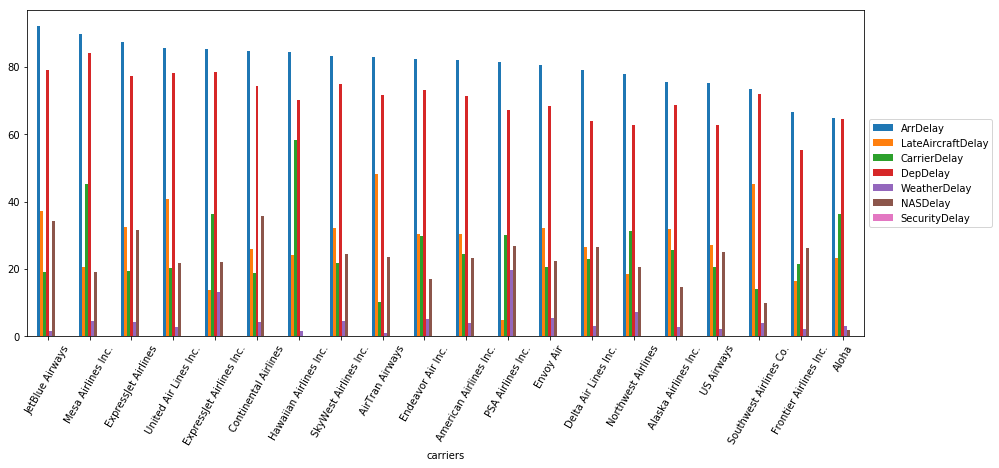

In [184]:
# plot of average minutes of delay type per carrier
arrivals[arrivals.Late_arrivals==1].groupby('carriers')['ArrDelay','LateAircraftDelay','CarrierDelay',
                                                        'DepDelay','WeatherDelay','NASDelay','SecurityDelay'].mean().sort_values(by='ArrDelay',ascending=False).plot(kind='bar',figsize=(15,6))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=60)
# table of average minutes of delay type per carrier
arrivals[arrivals.Late_arrivals==1].groupby('carriers')['ArrDelay','LateAircraftDelay','CarrierDelay',
                                                        'DepDelay','WeatherDelay','NASDelay','SecurityDelay'].mean().sort_values(by='ArrDelay',ascending=False)

We can see from the bar plot that departure delays are the most significant of all of the other types of delays.

In [35]:
# number of flight per carrier in 2008

arrivals.carriers.value_counts()

Southwest Airlines Co.      1186911
American Airlines Inc.       585485
SkyWest Airlines Inc.        553412
Envoy Air                    471161
US Airways                   446086
Delta Air Lines Inc.         443934
United Air Lines Inc.        437979
ExpressJet Airlines          363414
Northwest Airlines           344110
Continental Airlines         293855
ExpressJet Airlines Inc.     274867
AirTran Airways              258713
Endeavor Air Inc.            254322
Mesa Airlines Inc.           245131
JetBlue Airways              192114
PSA Airlines Inc.            190695
Alaska Airlines Inc.         148492
Frontier Airlines Inc.        95384
Hawaiian Airlines Inc.        61212
Aloha                          7752
Name: carriers, dtype: int64

In [190]:
# create new feature that bins flights by season

bins=['2008-01-01','2008-03-19','2008-06-01','2008-09-23','2008-12-21','2008-12-31']
bin_names = ['winter','spring','summer','fall','Winter']
arrivals['seasons'] = pd.cut(arrivals.date, pd.to_datetime(bins),labels=bin_names)
arrivals['seasons'] = arrivals['seasons'].str.lower()

In [191]:
# create ne feature that bins flights by time of day

bins=[0,600,1159,1700,2000,2359]
bin_names = ['night','morning','afternoon','evening','Night']
arrivals['time_of_day'] = pd.cut(arrivals.ArrTime, bins,labels=bin_names)
arrivals['time_of_day'] = arrivals['time_of_day'].str.lower()

In [39]:
#arr_samp = arrivals.sample(frac=.001)

In [192]:
#average delays by season
arrivals[['ArrDelay','WeatherDelay','LateAircraftDelay',
          'CarrierDelay','SecurityDelay','NASDelay']].groupby(arrivals.seasons).mean()

,ArrDelay,WeatherDelay,LateAircraftDelay,CarrierDelay,SecurityDelay,NASDelay
seasons,,,,,,
fall,4.345548,0.493398,3.550071,2.614045,0.010821,3.213152
spring,7.033542,0.453012,4.043349,3.233414,0.016162,3.450412
summer,8.336891,0.747849,4.500402,3.600772,0.015544,4.008711
winter,12.410679,0.942106,6.244061,4.434929,0.023595,4.437797


In [193]:
#average delays by time of day
arrivals[['ArrDelay','WeatherDelay','LateAircraftDelay',
          'CarrierDelay','SecurityDelay','NASDelay']].groupby(arrivals.time_of_day).mean()

,ArrDelay,WeatherDelay,LateAircraftDelay,CarrierDelay,SecurityDelay,NASDelay
time_of_day,,,,,,
afternoon,5.120371,0.475024,2.971315,3.137575,0.014696,2.973714
evening,10.165684,0.734929,5.308944,3.641301,0.014898,4.698797
morning,-0.694553,0.258270,0.660629,1.858909,0.014285,1.902065
night,21.732183,1.424254,11.253867,5.952219,0.023750,6.637234


In [194]:
#average delays by month

print('Mean Delays per Month')
arrivals[['ArrDelay','WeatherDelay','LateAircraftDelay',
          'CarrierDelay','SecurityDelay','NASDelay']].groupby(arrivals.date.dt.strftime('%B')).mean()

Mean Delays per Month


,ArrDelay,WeatherDelay,LateAircraftDelay,CarrierDelay,SecurityDelay,NASDelay
date,,,,,,
April,6.807297,0.458148,3.881411,3.283945,0.013030,3.347414
August,6.910915,0.664013,4.145521,3.546540,0.012341,3.443609
December,16.680505,1.425371,8.154635,4.956693,0.023213,5.544379
February,13.077837,0.995248,6.390792,4.385055,0.020773,4.703833
January,10.188856,0.732083,5.357907,4.012662,0.021992,4.125458
July,9.975050,0.903109,4.976889,3.927538,0.021328,4.413285
June,13.266756,0.960323,6.013255,4.168668,0.017825,5.419220
March,11.192365,0.793336,5.589174,4.224826,0.025265,4.156701
May,5.978448,0.400549,3.745371,2.874837,0.016273,3.332172


In [50]:
arrivals = arrivals.sample(frac=.0003)


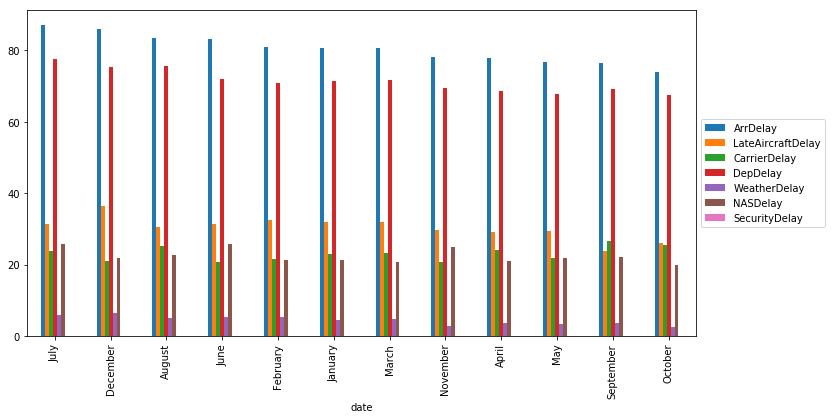

In [198]:
arrivals[arrivals.Late_arrivals==1].groupby(arrivals.date.dt.strftime('%B'))['ArrDelay','LateAircraftDelay','CarrierDelay',
                                                        'DepDelay','WeatherDelay','NASDelay','SecurityDelay'].mean().sort_values(by='ArrDelay',ascending=False).plot(kind='bar',figsize=(12,6))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


We always seem to feel like weather would be the major cause of flight delays. The above chart shows that weather delays are second to only security delays which are virtually non-existent.

In [53]:
arrivals[arrivals.Late_arrivals==1].groupby(arrivals.date.dt.strftime('%B')).ArrDelay.mean()

date
April         84.562500
August       105.550000
December      78.483871
February      76.038462
January       69.961538
July         115.500000
June          75.600000
March         95.708333
May           62.250000
November      84.538462
October       52.300000
September     79.545455
Name: ArrDelay, dtype: float64

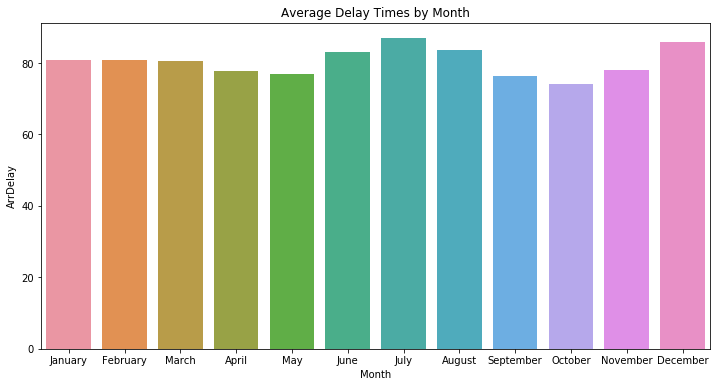

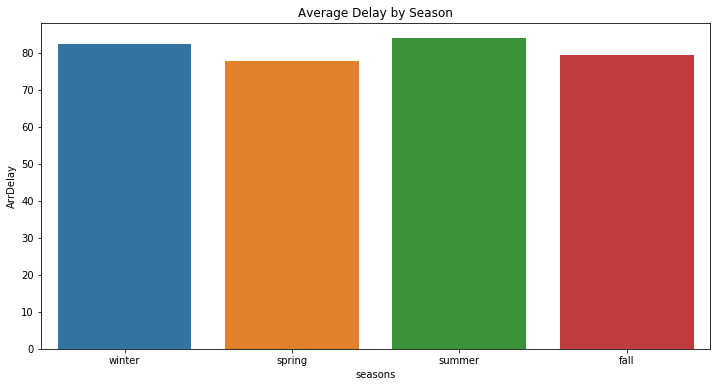

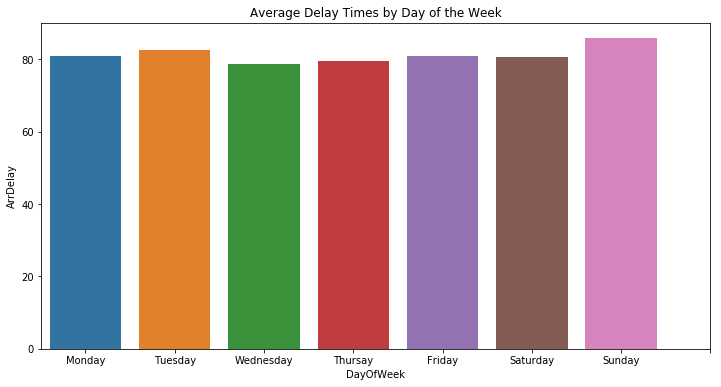

In [200]:
plt.figure(figsize=(12, 6))
sns.barplot(arrivals.sort_values(by='date').date.dt.strftime('%B'),arrivals[arrivals.Late_arrivals==1].ArrDelay, ci=None)
plt.title('Average Delay Times by Month') 
plt.xlabel('Month')
plt.show()


plt.figure(figsize=(12, 6))
sns.barplot(arrivals.seasons,arrivals[arrivals.Late_arrivals==1].ArrDelay,ci=None)
plt.title('Average Delay by Season')
plt.show()


plt.figure(figsize=(12, 6))
sns.barplot(arrivals.DayOfWeek,arrivals[arrivals.Late_arrivals==1].ArrDelay,ci=None)
plt.title('Average Delay Times by Day of the Week')
plt.xticks([0,1,2,3,4,5,6,7], ["Monday", "Tuesday", "Wednesday", "Thursay","Friday","Saturday","Sunday"])
plt.show()




The above bar plots are the average delay times in minutes for looking at late arrivals only (arrivals that were more than 30 min delayed)

In [45]:
 arrivals.groupby(by=arrivals.date.dt.strftime('%B')).ArrDelay.describe()

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
April,586723.0,6.807297,35.330544,-89.0,-10.0,-2.0,11.0,2453.0
August,600750.0,6.910915,38.390843,-92.0,-11.0,-3.0,9.0,1359.0
December,524747.0,16.680505,48.570617,-90.0,-8.0,2.0,23.0,1655.0
February,546925.0,13.077837,42.510286,-90.0,-8.0,1.0,18.0,2461.0
January,587130.0,10.188856,39.800727,-91.0,-10.0,0.0,15.0,1525.0
July,615423.0,9.975050,42.034384,-109.0,-10.0,-2.0,12.0,1510.0
June,595458.0,13.266756,42.788612,-87.0,-8.0,0.0,17.0,1707.0
March,598343.0,11.192365,40.478498,-86.0,-9.0,0.0,16.0,1490.0
May,599210.0,5.978448,33.994879,-129.0,-10.0,-2.0,10.0,1951.0


In [46]:
arrivals[(arrivals['ArrDelay'] >=2453) & (arrivals['ArrDelay'] <=2461)] 

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Late_arrivals,Late_departures,date,carriers,seasons,time_of_day
1018798,7,1117.0,1820,2256.0,555,NW,459.0,455.0,437.0,2461.0,2457.0,HNL,MSP,3972,6.0,16.0,1455.0,0.0,4.0,0.0,1002.0,1,1,2008-02-03,Northwest Airlines,winter,night
2235378,4,724.0,1417,858.0,1605,NW,154.0,168.0,132.0,2453.0,2467.0,CLT,MSP,930,8.0,14.0,2436.0,0.0,0.0,0.0,17.0,1,1,2008-04-10,Northwest Airlines,spring,morning


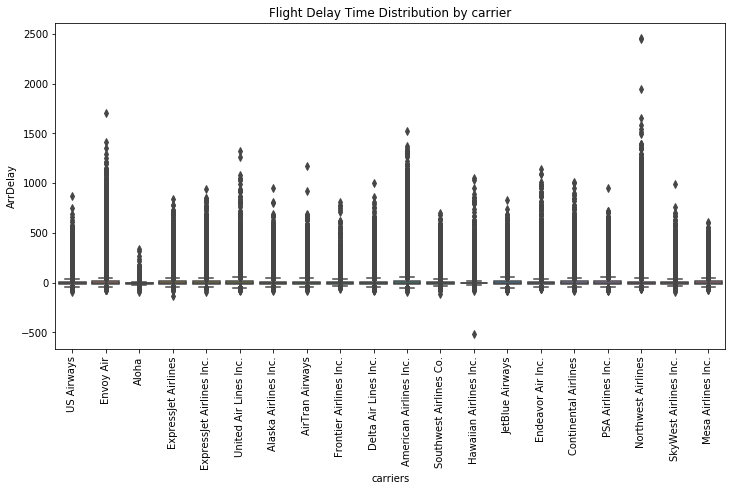

In [202]:
plt.figure(figsize=(12, 6))
sns.boxplot(arrivals.sort_values(by='date').carriers,arrivals.ArrDelay)
plt.title('Flight Delay Time Distribution by carrier')
plt.xticks(rotation=90)
plt.show()
 

In [208]:
mean_1 = np.mean(arrivals[arrivals.Late_arrivals==1].ArrDelay)
std_1 =np.std(arrivals[arrivals.Late_arrivals==1].ArrDelay)
    
outliers=[]    
for y in arrivals[arrivals.Late_arrivals==1].ArrDelay:
    z_score= (y - mean_1)/std_1 
    if np.abs(z_score) > 3:
        outliers.append(y)

In [209]:
min(outliers)

273.0

In [210]:
no_outies = arrivals[(arrivals['ArrDelay'] >30) & (arrivals['ArrDelay'] <273)] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001875C445748>,
      dtype=object)

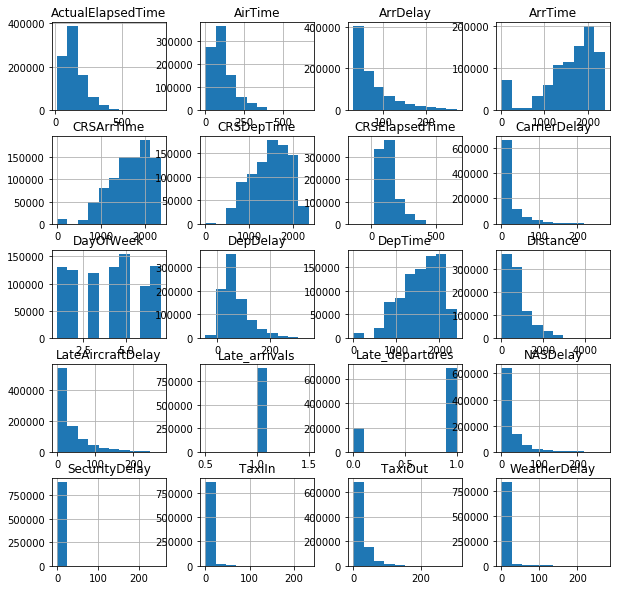

In [212]:
no_outies.hist(figsize=(10,10))

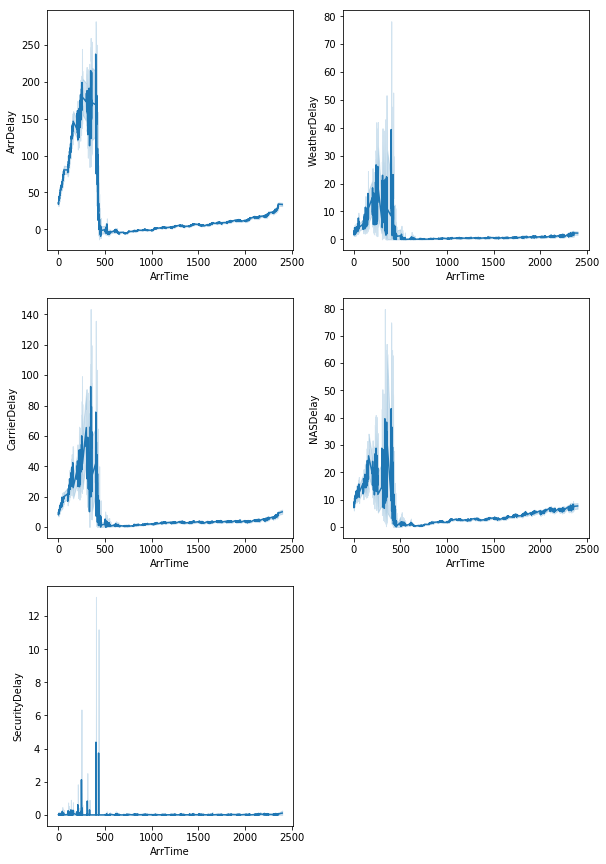

In [48]:
plt.figure(figsize=(17, 15))
 
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[2, 0])

sns.lineplot(arrivals[arrivals.Late_arrivals==1]['ArrTime'].sort_values(), arrivals['ArrDelay'],ax=ax1) 
sns.lineplot(arrivals[arrivals.Late_arrivals==1]['ArrTime'].sort_values(), arrivals['WeatherDelay'],ax=ax2) 
sns.lineplot(arrivals[arrivals.Late_arrivals==1]['ArrTime'].sort_values(), arrivals['CarrierDelay'],ax=ax3) 
sns.lineplot(arrivals[arrivals.Late_arrivals==1]['ArrTime'].sort_values(), arrivals['NASDelay'],ax=ax4) 
sns.lineplot(arrivals[arrivals.Late_arrivals==1]['ArrTime'].sort_values(), arrivals['SecurityDelay'],ax=ax5)
plt.show()

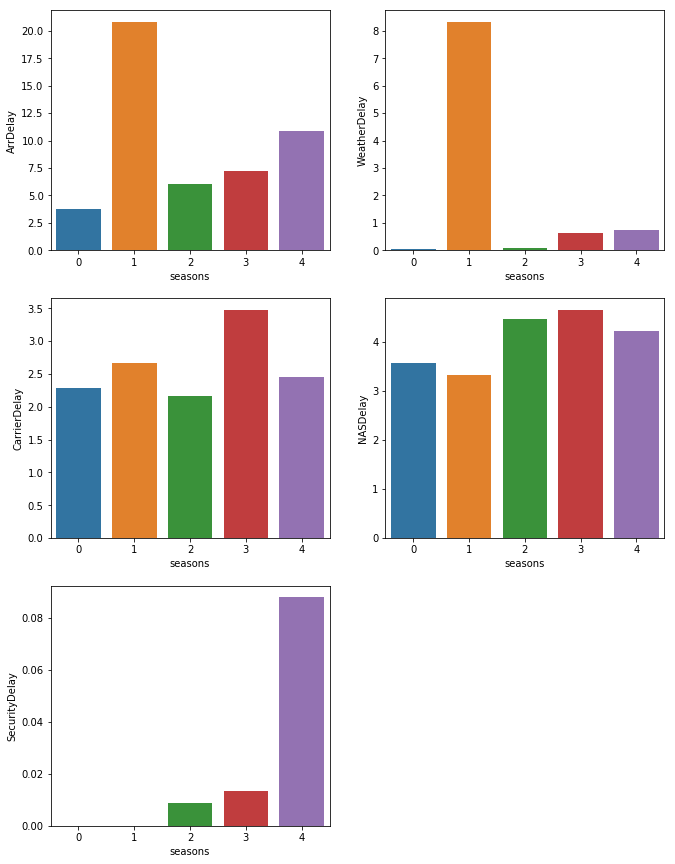

In [145]:
plt.figure(figsize=(17, 15))
 
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[2, 0])

 
sns.barplot(arrivals['seasons'].sort_values(), arrivals['ArrDelay'],ci=None,ax=ax1) 
sns.barplot(arrivals['seasons'].sort_values(), arrivals['WeatherDelay'],ci=None,ax=ax2) 
sns.barplot(arrivals['seasons'].sort_values(), arrivals['CarrierDelay'],ci=None,ax=ax3) 
sns.barplot(arrivals['seasons'].sort_values(), arrivals['NASDelay'],ci=None,ax=ax4) 
sns.barplot(arrivals['seasons'].sort_values(), arrivals['SecurityDelay'],ci=None,ax=ax5)
plt.show()

In [ ]:
print(np.cov(arr_samp.SecurityDelay, arr_samp.ArrDelay))
print(np.cov(arr_samp.NASDelay, arr_samp.ArrDelay))

In [ ]:
plt.figure(figsize=(17, 12))
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1,0])
#ax4 = plt.subplot(gs[1,1])
#ax5 = plt.subplot(gs[2, 0])



sns.regplot(arr_samp[arr_samp.WeatherDelay>0].WeatherDelay, arr_samp[arr_samp.WeatherDelay>0].ArrDelay,ax=ax1)


 
sns.regplot(arr_samp[arr_samp.NASDelay>0].NASDelay, arr_samp[arr_samp.NASDelay>0].ArrDelay,ax=ax2)


sns.regplot(arr_samp[arr_samp.CarrierDelay>0].CarrierDelay, arr_samp[arr_samp.CarrierDelay>0].ArrDelay,ax=ax3)
 

In [ ]:
plt.boxplot(arr_samp[arr_samp.WeatherDelay>0].WeatherDelay)
plt.show



In [ ]:
plt.boxplot(arr_samp[arr_samp.ArrDelay>0].ArrDelay)
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.hist(np.where(arr_samp['DepDelay']>30, 'Late', 'On-Time'))
plt.title('Late flight Distribution')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

In [ ]:
 pd.DataFrame(pd.Series(arr_samp['Origin'].unique()))

In [ ]:
arr_samp.groupby('Origin').Late_arrivals.value_counts()

In [ ]:
bins=['2008-01-01','2008-03-19','2008-06-01','2008-09-23','2008-12-21','2008-12-31']
bin_names = ['winter','spring','summer','fall','Winter']
arr_samp['seasons'] = pd.cut(arr_samp.date, pd.to_datetime(bins),labels=bin_names)
arr_samp['seasons'] = arr_samp['seasons'].str.lower()

In [17]:
arrivals.fillna({'CarrierDelay':0,
       'WeatherDelay':0, 'NASDelay':0, 'SecurityDelay':0, 'LateAircraftDelay':0}, inplace=True)

In [18]:
arrivals.dropna(inplace=True)

In [19]:
arrivals['Late_arrivals'] = np.where(arrivals['ArrDelay']>30, 1, 0)
arrivals['Late_departures'] = np.where(arrivals['DepDelay']>30, 1, 0)

In [20]:
len(arrivals)

6855029

In [21]:
arrivals['Day'] = arrivals['DayofMonth'] 
arrivals['date'] = pd.to_datetime(arrivals[['Year','Month','Day']])
arrivals = arrivals.drop(['Year','DayofMonth','Day','Month'],1)

In [23]:
bins=['2008-01-01','2008-03-19','2008-06-01','2008-09-23','2008-12-21','2008-12-31']
bin_names = ['winter','spring','summer','fall','Winter']
arrivals['seasons'] = pd.cut(arrivals.date, pd.to_datetime(bins),labels=bin_names)
arrivals['seasons'] = arrivals['seasons'].str.lower()


bins=[0,600,1159,1700,2000,2359]
bin_names = ['night','morning','afternoon','evening','Night']
arrivals['time_of_day'] = pd.cut(arrivals.ArrTime, bins,labels=bin_names)
arrivals['time_of_day'] = arrivals['time_of_day'].str.lower()

In [24]:
arrivals['seasons'] = arrivals.seasons.astype(str)
arrivals['time_of_day'] = arrivals.seasons.astype(str)

In [93]:
from sklearn import preprocessing 
  
# label_encoder object  
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column  
arrivals['seasons']= label_encoder.fit_transform(arrivals['seasons'].astype(str)) 
arrivals['time_of_day']= label_encoder.fit_transform(arrivals['time_of_day']) 
 
print(arrivals['seasons'].unique())
print(arrivals['time_of_day'].unique()) 

[4 2 3 0 1]
[3 2 0 1]


In [94]:
label_encoder.inverse_transform(arrivals['seasons'])
arrivals.seasons.value_counts()

ValueError: y contains previously unseen labels: [4]

In [27]:
len(arrivals)

6855029

519389         night
1614176      morning
2333706    afternoon
4074659    afternoon
6494279      morning
2520018      morning
2776134    afternoon
3387004    afternoon
302903       morning
4307243    afternoon
2127122      evening
6176049    afternoon
930339       evening
912533       evening
631772       evening
5047985      morning
936576         night
2695779      evening
5255503    afternoon
6946419      evening
6014706    afternoon
3696309        night
2093400      morning
5899876      evening
235339       morning
6963036      evening
5301716    afternoon
3603885        night
2609877      evening
5510536      evening
2228734        night
4889702      morning
6501626        night
2981133        night
623165       evening
5809700      evening
3554518        night
4770391        night
1127644      evening
3439191    afternoon
3294926        night
6829070    afternoon
4522207    afternoon
4005675      morning
3953468      morning
5364813        night
331717       evening
6164792      

In [144]:
from sklearn import preprocessing 
  
# label_encoder object  
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column  
arrivals['seasons']= label_encoder.fit_transform(arrivals['seasons']) 
arrivals['time_of_day']= label_encoder.fit_transform(arrivals['time_of_day']) 
 
print(arrivals['seasons'].unique())
print(arrivals['time_of_day'].unique()) 


[4 2 3 0 1]
[3 2 0 1]


# MODELING

### Preprocessing

In [213]:



features =  ['DayOfWeek', 'DepTime', 'CRSDepTime',   'CRSArrTime',
             'ActualElapsedTime','CRSElapsedTime', 'AirTime','DepDelay',  
             'Distance', 'TaxiIn', 'TaxiOut',   'CarrierDelay','WeatherDelay',
             'NASDelay', 'SecurityDelay', 'LateAircraftDelay','Late_arrivals', 
             'Late_departures']

Y = no_outies['ArrDelay'] 
X = no_outies[features]



from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)

 # Automatic feature selection with SelectKbest
import sklearn.feature_selection 
select =sklearn.feature_selection.SelectKBest()
selected_features = select.fit(X_train, y_train)
indicies_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indicies_selected]
X_selected = X[colnames_selected]
print(colnames_selected)
x_train_selected = X_train[colnames_selected]
x_test_selected = X_test[colnames_selected]

X = arrivals[colnames_selected]
Y = arrivals['ArrDelay']

# Standardizing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(x_train_selected) 
X_train = scaler.transform(x_train_selected)
X_test = scaler.transform(x_test_selected)


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [16] are constant.
  UserWarning)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


['DepTime', 'CRSDepTime', 'CRSArrTime', 'DepDelay', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'Late_departures']


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:38: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:39: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.


# MODELING

### Linear regression

In [214]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()

regr.fit(X_train,y_train)

print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X_test, y_test).score(X_test, y_test)))
print()
from sklearn.model_selection import cross_val_score
print(cross_val_score(regr, X_test, y_test, cv=10))

 
 
 
# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_test, y_test))

With 20% Holdout: 0.9979119149703497
Testing on Sample: 0.9979124294893914

[0.99826008 0.99767425 0.9971991  0.9981874  0.99836372 0.99881342
 0.99790234 0.99707759 0.99693868 0.99869632]

Coefficients: 
 [-1.44038146e-02 -4.04468486e-02 -2.19302614e-02  1.36287827e+00
  3.71967384e-01  3.66387282e+01  1.91317742e+01  3.49125207e+01
  4.20405118e+01 -1.36509448e-01]

Intercept: 
 76.28963290053775

R-squared:
0.9979124294893914


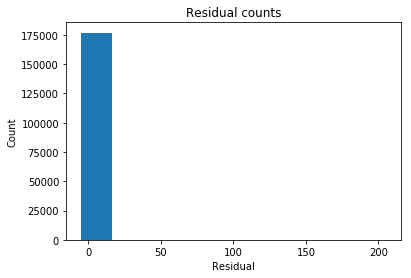

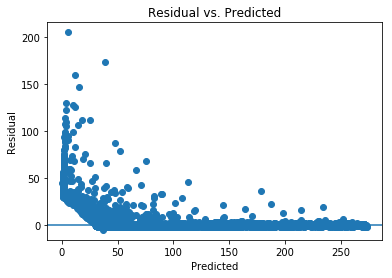

RMSE: 2.149809503148055


In [215]:
predicted = regr.predict(X_test) 
actual = y_test
# Calculate the error 
residual = actual - predicted

 
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()



plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
print ('RMSE:',(((predicted - actual) ** 2).mean() ** .5) )  


In [216]:
# Tuning hyperparameters
param_grid = dict(normalize=[True,False],copy_X=[True,False])
grid = GridSearchCV(regr, param_grid, cv=5, scoring="r2", return_train_score=True)
grid.fit(X_train, y_train)


print(grid.best_params_)
print(grid.best_score_ )

{'copy_X': True, 'normalize': True}
0.9980646684894383


In [217]:
# Instantiate and fit our model.
 
regr = linear_model.LinearRegression(copy_X=True, normalize=True) 
regr.fit(X_train,y_train)


print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit( X_test , y_test).score(X_test, y_test)))
print()
from sklearn.model_selection import cross_val_score
print(cross_val_score(regr, X_test, y_test, cv=10))
 
 
 
# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_test, y_test))


With 20% Holdout: 0.9979119149703497
Testing on Sample: 0.9979124294893914

[0.99826008 0.99767425 0.9971991  0.9981874  0.99836372 0.99881342
 0.99790234 0.99707759 0.99693868 0.99869632]

Coefficients: 
 [-1.44038146e-02 -4.04468486e-02 -2.19302614e-02  1.36287827e+00
  3.71967384e-01  3.66387282e+01  1.91317742e+01  3.49125207e+01
  4.20405118e+01 -1.36509448e-01]

Intercept: 
 76.28963290053775

R-squared:
0.9979124294893914


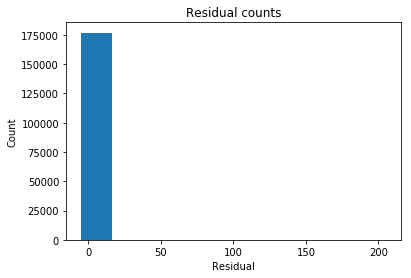

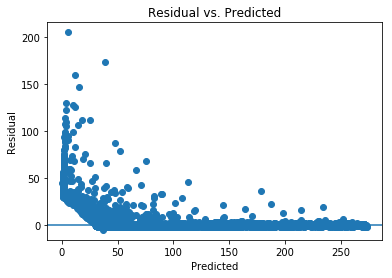

RMSE: 2.1498095031480555


In [218]:
predicted = regr.predict(X_test) 
actual = y_test
# Calculate the error 
residual = actual - predicted

 
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()



plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
print ('RMSE:',(((predicted - actual) ** 2).mean() ** .5) )  
 

 ### KNN regression
 

In [219]:
from sklearn import neighbors
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10) 
knn.fit(X_train, y_train)


print('With 20% Holdout: ' + str(knn.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(knn.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(knn, X_test, y_test, cv=10))

 

KeyboardInterrupt: 

In [102]:
param_grid = dict(leaf_size=range(1,30),p=(1,2),n_neighbors=range(1,12),weights=['distance','uniform'])
grid = GridSearchCV(knn, param_grid, cv=3, scoring="r2", return_train_score=True,n_jobs = -1)
grid.fit(X_train, y_train)


print(grid.best_params_)
print(grid.best_score_ )

{'leaf_size': 3, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.887064700513291


In [103]:
#fit with new parameters
knn = neighbors.KNeighborsRegressor(n_neighbors=1,p=1,leaf_size=1,weights='distance') 
knn.fit(X_train, y_train)


print('With 20% Holdout: ' + str(knn.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(knn.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(knn, X_test, y_test, cv=10))

With 20% Holdout: 0.8223341108569283
Testing on Sample: 0.9854147327710937

[0.82666469 0.6446791  0.61742627 0.84211797 0.49350803 0.91029558
 0.88754531 0.76241165 0.87852487 0.51793213]


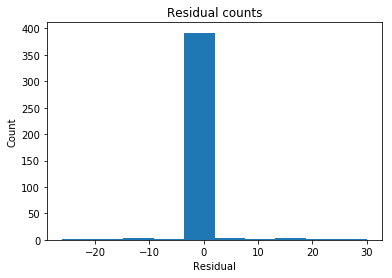

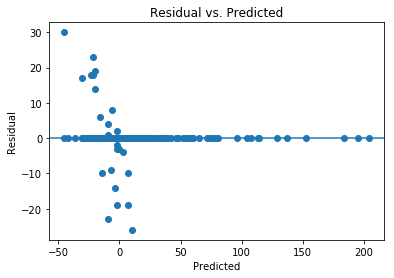

RMSE: 3.6490456259935313


In [104]:
predicted = knn.predict(X_test) 
actual = y_test
# Calculate the error 
residual = actual - predicted

 
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()



plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
print ('RMSE:',(((predicted - actual) ** 2).mean() ** .5) )  
 

### Decision Trees

In [220]:
from sklearn.tree import DecisionTreeRegressor
# Fit regression tree model
regr_t = DecisionTreeRegressor(max_depth=2,random_state=20) 
regr_t.fit(X_train, y_train)


print('With 20% Holdout: ' + str(regr_t.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr_t.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(regr_t, X_test, y_test, cv=10))

 

With 20% Holdout: 0.7762358189913833
Testing on Sample: 0.77637392029392

[0.77244054 0.7727981  0.77037285 0.77699442 0.7791638  0.78116438
 0.77446116 0.78122052 0.7799753  0.77418168]


In [106]:
param_grid = dict(max_depth=range(1,5),max_leaf_nodes=range(6,20),max_features=['sqrt',4])
grid = GridSearchCV(regr_t, param_grid, cv=3, scoring="r2", return_train_score=True,n_jobs = -1)
grid.fit(X_train, y_train)


print(grid.best_params_)
print(grid.best_score_ )

{'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 17}
0.8735520692168189


In [ ]:
regr_t = DecisionTreeRegressor(max_depth=15, random_state=20) 
regr_t.fit(X_train, y_train)


print('With 20% Holdout: ' + str(regr_t.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr_t.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(regr_t, X_test, y_test, cv=10))

 

With 20% Holdout: 0.9915101637966
Testing on Sample: 0.9950472904546761



### Random forrest

In [108]:
from sklearn import ensemble
rfrg = ensemble.RandomForestRegressor(criterion='mse',random_state=20, max_features='sqrt') 
rfrg.fit(X_train,y_train)


print('With 20% Holdout: ' + str(rfrg.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(rfrg.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(rfrg, X_test, y_test, cv=10))



With 20% Holdout: 0.8926063568530971
Testing on Sample: 0.9671226470953865

[0.8895448  0.5614675  0.76818341 0.85585198 0.68905302 0.90273758
 0.92517569 0.87735546 0.87472451 0.88482474]


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [109]:
param_grid = dict(max_depth=range(1,5),max_leaf_nodes=range(6,20),max_features=['sqrt',4,'auto'])
grid = GridSearchCV(rfrg, param_grid, cv=3, scoring="r2", return_train_score=True,n_jobs = -1)
grid.fit(X_train, y_train)


print(grid.best_params_)
print(grid.best_score_ )

{'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': 19}
0.9161880377899506


In [110]:
rfrg = ensemble.RandomForestRegressor(criterion='mse',random_state=20, max_features= 'auto',max_leaf_nodes=19,max_depth=4) 
rfrg.fit(X_train,y_train)


print('With 20% Holdout: ' + str(rfrg.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(rfrg.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(rfrg, X_test, y_test, cv=10))



With 20% Holdout: 0.8981012896288884
Testing on Sample: 0.9210895343576779

[0.88341517 0.76541129 0.7829128  0.90898807 0.67675668 0.94955144
 0.92559861 0.88562363 0.93319262 0.79326879]


c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Support Vector Machine

In [117]:
from sklearn.svm import SVR

# Instantiate our model and fit the data.
svm = SVR(kernel = 'linear')
svm.fit(X_train, y_train)


print('With 20% Holdout: ' + str(svm.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(svm.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(svm, X_test, y_test, cv=10))


With 20% Holdout: 0.9158363408308486
Testing on Sample: 0.9151604555401057

[0.88175074 0.7576479  0.94737828 0.92936288 0.71852524 0.9504754
 0.94626772 0.8847181  0.94897209 0.9055619 ]


In [118]:
param_grid = dict(C=np.arange(.1,5,.1))
grid = GridSearchCV(svm, param_grid, cv=3, scoring="r2", return_train_score=True,n_jobs = -1)
grid.fit(X_train, y_train)


print(grid.best_params_)
print(grid.best_score_ )

{'C': 4.9}
0.9526951607751275


In [119]:
# Instantiate our model and fit the data.
svm = SVR(kernel = 'linear',C=4.9)
svm.fit(X_train, y_train)


print('With 20% Holdout: ' + str(svm.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(svm.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(svm, X_test, y_test, cv=10))


With 20% Holdout: 0.915790459685434
Testing on Sample: 0.9162286726723479

[0.88492361 0.75870494 0.94242741 0.93320671 0.71957495 0.94967856
 0.94639005 0.8860337  0.94326342 0.90686347]


### Gradient boost

In [120]:
from sklearn import ensemble 
 
# Initialize and fit the model.
clf = ensemble.GradientBoostingRegressor(n_estimators=500,max_depth=2,
                                          loss='ls', random_state=20) 
clf.fit(X_train, y_train)


print('With 20% Holdout: ' + str(clf.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(clf.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(clf, X_test, y_test, cv=10))


With 20% Holdout: 0.9105717434210875
Testing on Sample: 0.9516127827743578

[0.89644295 0.68232086 0.85937645 0.90877854 0.67540924 0.95114301
 0.91034673 0.88175259 0.94415856 0.84690803]


In [124]:
param_grid = dict(n_estimators=np.arange(600,1000,100),max_depth=range(1,4),
                  loss=['ls', 'lad', 'huber', 'quantile'],learning_rate=np.arange(.1,2,.1))
grid = GridSearchCV(clf, param_grid, cv=3, scoring="r2", return_train_score=True,n_jobs = -1)
grid.fit(X_train, y_train)


print(grid.best_params_)
print(grid.best_score_ )

c:\users\keith\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.6, 'loss': 'huber', 'max_depth': 1, 'n_estimators': 800}
0.9464071078315028


In [125]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingRegressor(loss='ls', max_depth=1, n_estimators=800,random_state=20,learning_rate=.6) 
clf.fit(X_train, y_train)


print('With 20% Holdout: ' + str(clf.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(clf.fit( X_test , y_test).score(X_test, y_test)))
print() 
print(cross_val_score(clf, X_test, y_test, cv=10))



With 20% Holdout: 0.9058566332630565
Testing on Sample: 0.94102506475775

[0.87553183 0.68462308 0.88221494 0.92292342 0.67940062 0.92260155
 0.92402442 0.88865156 0.92613838 0.84197668]
